### Generate Tool Scripts for Offline DRL Algorithms with Simulated Data

This notebook allows for generating the command line scripts to run offline DRL algorithms. To run these, complete the following steps:


To run experiments on the simulated data once the appropriate data source files are
available, the following process was developed and used:

1. Ensure the raw in-silico datasets are properly placed with the environment variable 'SIM_DATA_PATH', with SIM_DATA_PATH such that the file structure follows SIM_DATA_PATH/object_save/data_dictionary_{subj_name}_data.pkl.

2. Run utils/sim_data.py, choosing the “import” option when prompted.

3. Under the code for the “convert 2” case, alter the parameters to match the desired configuration OR set data_preload to false under the agent parameters, and set the configuration, skip to step 5.

4. Run utils/sim_data.py, choosing the “convert 2” option when prompted.

5. (optional) Re-run steps 3 and 4 with different data configurations, if the previous configuration is different from what is desired. This script may take a few hours to run depending on configuration.

6. In visualisor/notebooks/ORL_toolscriptgen.ipynb, in the first code cell, follow instructions to set parameters, and run it, obtaining the console commands to run each experiment with the needed parameters.

7. In a console, targeting the correct python environment, virtual or otherwise, run the commands from the experiments/ folder. This should take from 4 to 8 hours depending on computer specifications and chosen parameters.

8. Once the code has completed running, collect the results from the following cell in the same Jupyter notebook file, and store as needed.

9. (optional) Go to visualisor/notebooks/ORL_early_stopping.ipynb, and enter the experiment name and algorithm type. Run first cell to view the results of early stopping based on the validation trials, run the second to re-run those trials 50 times each, and run the third to generate a table of the results, with or without early stopping.

In [ ]:

name_prefix = "offline_td3_purebc"
agent = "iql" # Choose the offline RL agent based on available agents from set_agent_parameters() from the file run_RL_agent.py, currently 'iql' and 'td3+bc'
device = "cuda" # Choose device to run scripts on

custom_params = {
    "agent.beta" : "1"
}

for patient_id in list(range(0,10)) + list(range(20,30)):
    for seed in range(3):
        text = f"python run_RL_agent.py experiment.name={name_prefix}_{patient_id}_{seed} experiment.device={device} agent={agent} agent.debug=False hydra/job_logging=disabled mlflow.track=false agent.data_preload=true env.patient_id={patient_id} experiment.seed={seed}"
        for custom_param_key in custom_params:
            custom_param_val = custom_params[custom_param_key]
            text += f" {custom_param_key}={custom_param_val}"
        text += ';'
        print(text)

    print()

python run_RL_agent.py experiment.name=offline_td3_purebc_0_0 experiment.device=cuda agent=iql agent.debug=False hydra/job_logging=disabled mlflow.track=false agent.data_preload=true env.patient_id=0 experiment.seed=0 agent.beta=1;
python run_RL_agent.py experiment.name=offline_td3_purebc_0_1 experiment.device=cuda agent=iql agent.debug=False hydra/job_logging=disabled mlflow.track=false agent.data_preload=true env.patient_id=0 experiment.seed=1 agent.beta=1;
python run_RL_agent.py experiment.name=offline_td3_purebc_0_2 experiment.device=cuda agent=iql agent.debug=False hydra/job_logging=disabled mlflow.track=false agent.data_preload=true env.patient_id=0 experiment.seed=2 agent.beta=1;

python run_RL_agent.py experiment.name=offline_td3_purebc_1_0 experiment.device=cuda agent=iql agent.debug=False hydra/job_logging=disabled mlflow.track=false agent.data_preload=true env.patient_id=1 experiment.seed=0 agent.beta=1;
python run_RL_agent.py experiment.name=offline_td3_purebc_1_1 experimen

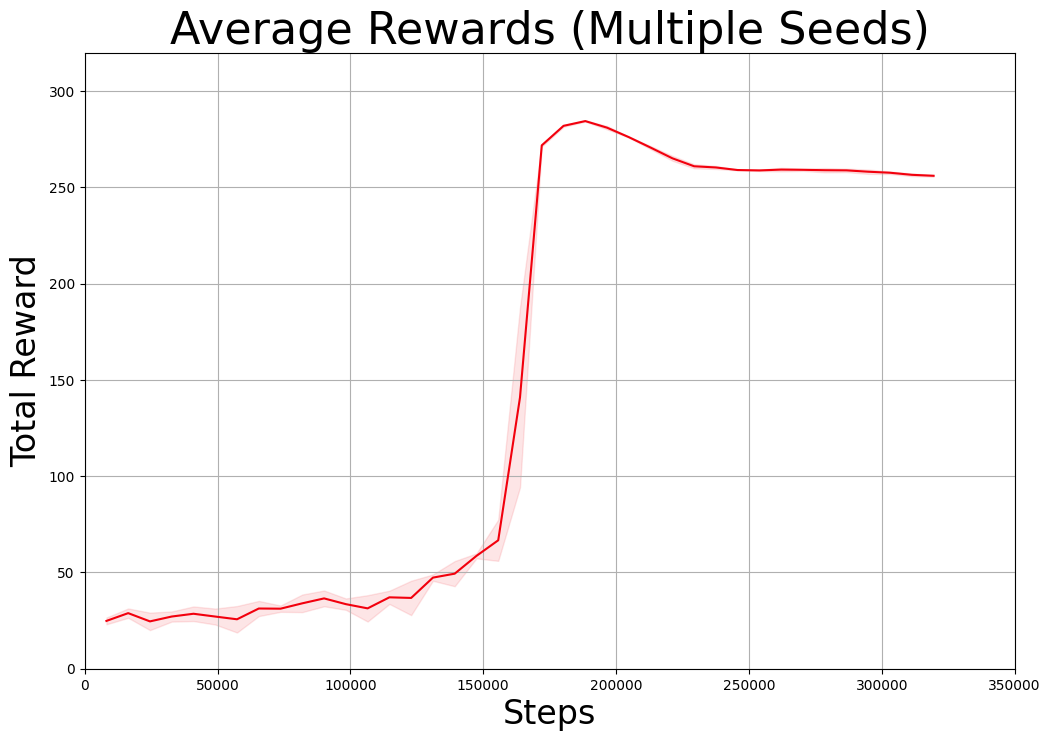

{'id': <visualiser.core.ExperimentVisualise object at 0x00000238E0BE6C30>, 'color': '#f2000d', 'show': True, 'label': 'offline_iql_t3_0_0'}


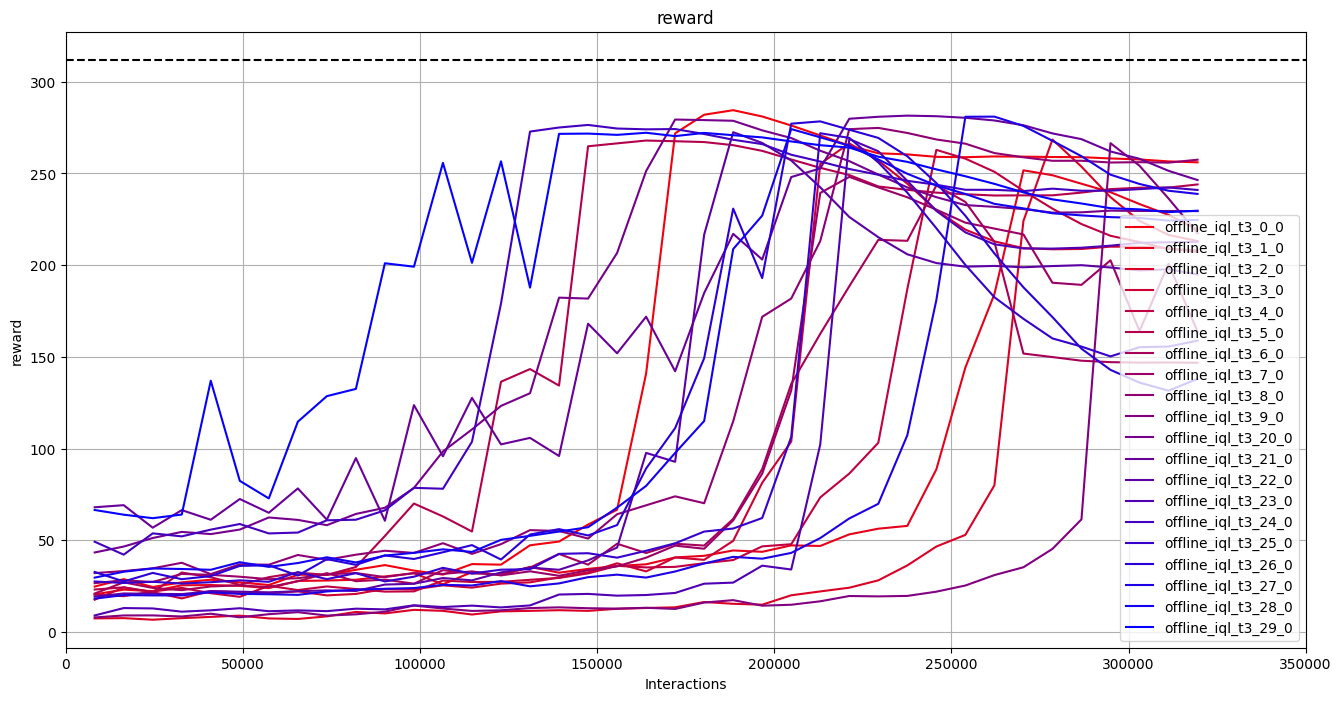

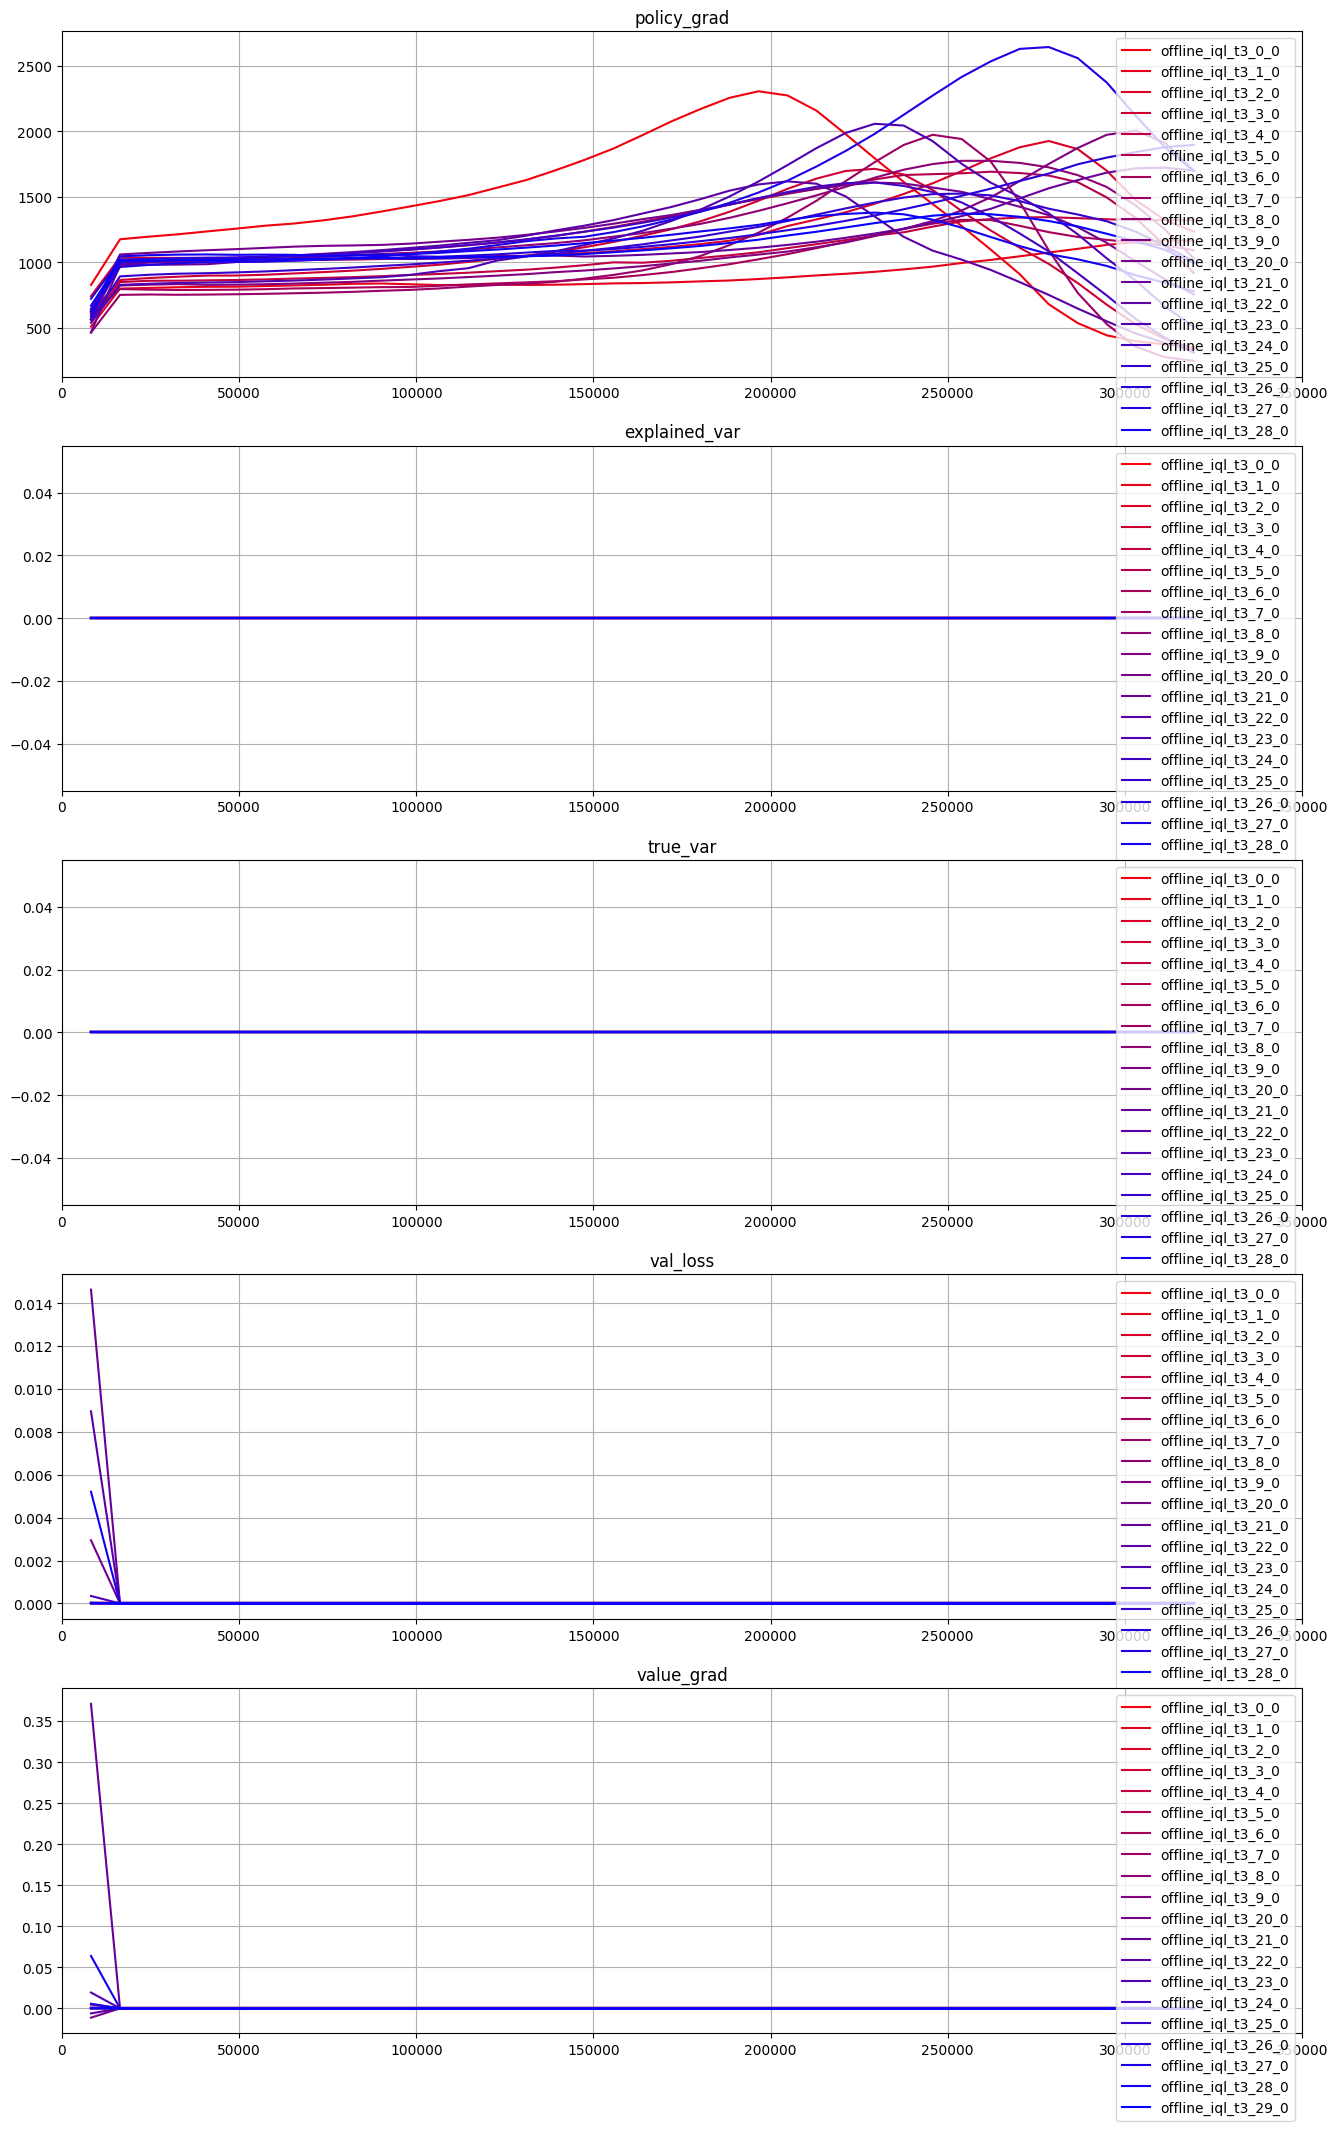

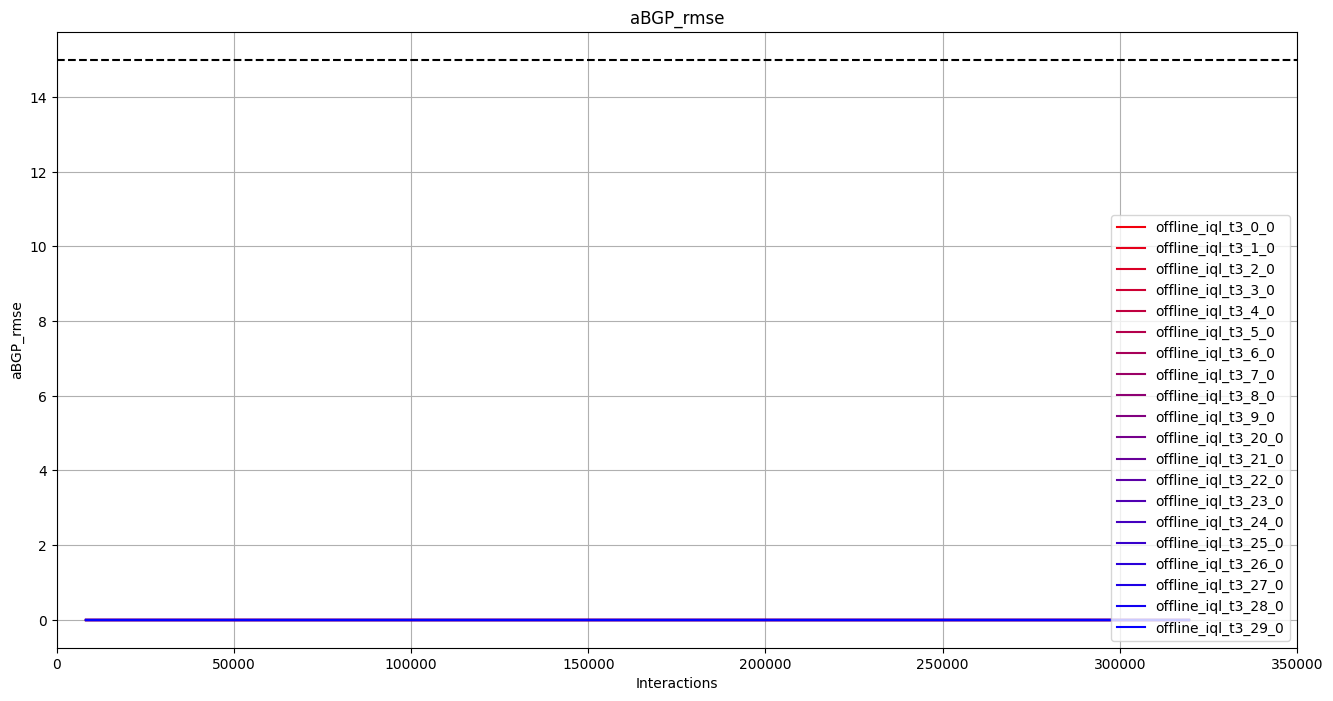

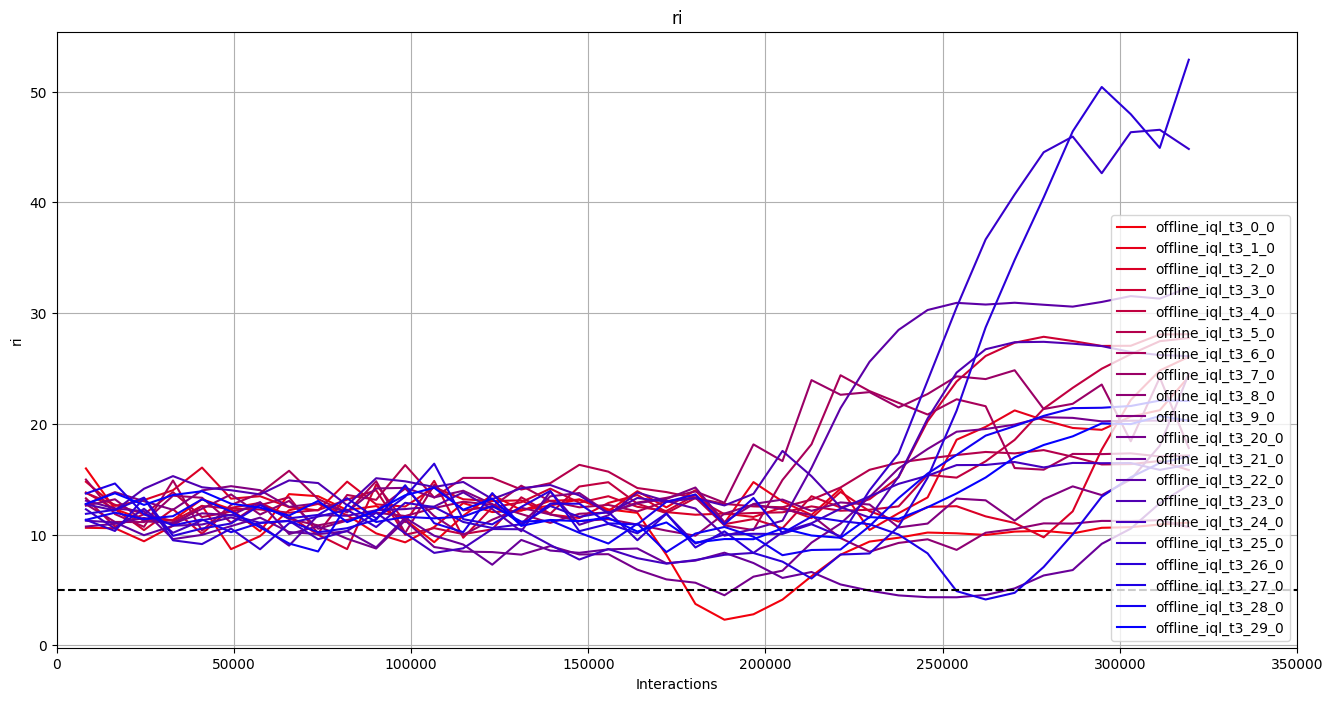

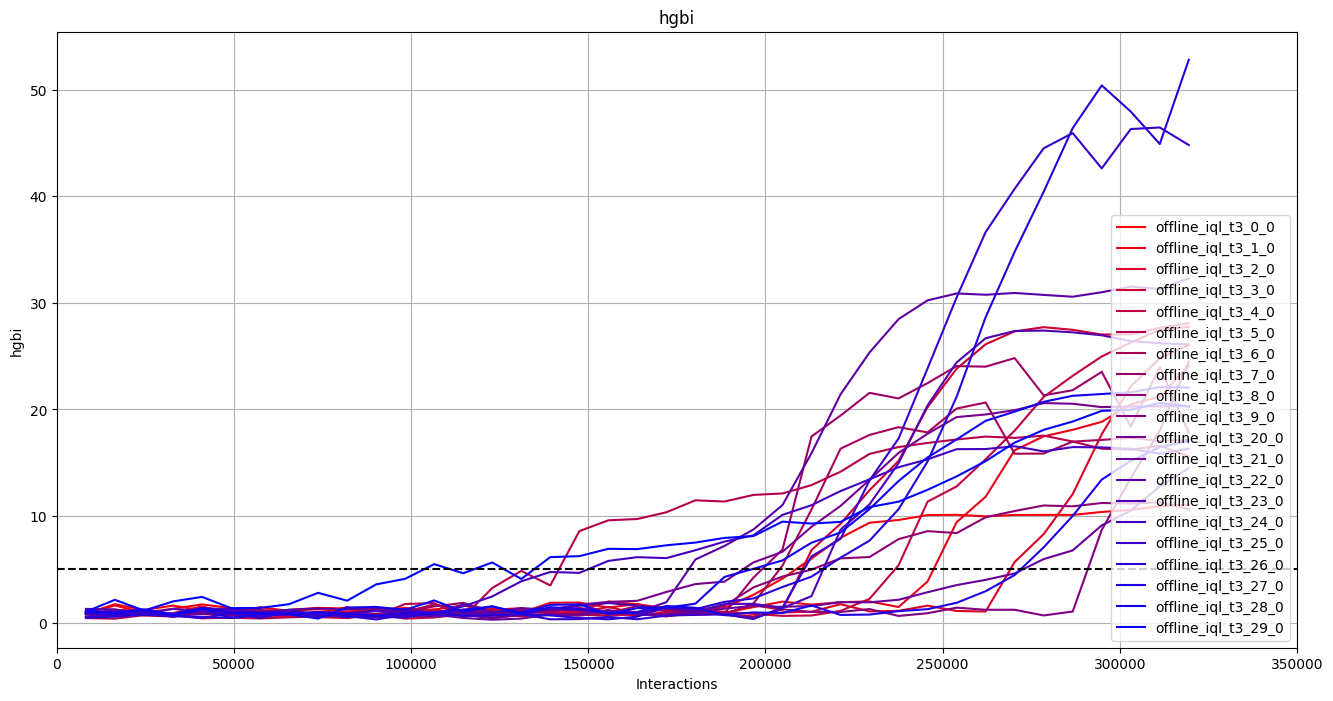

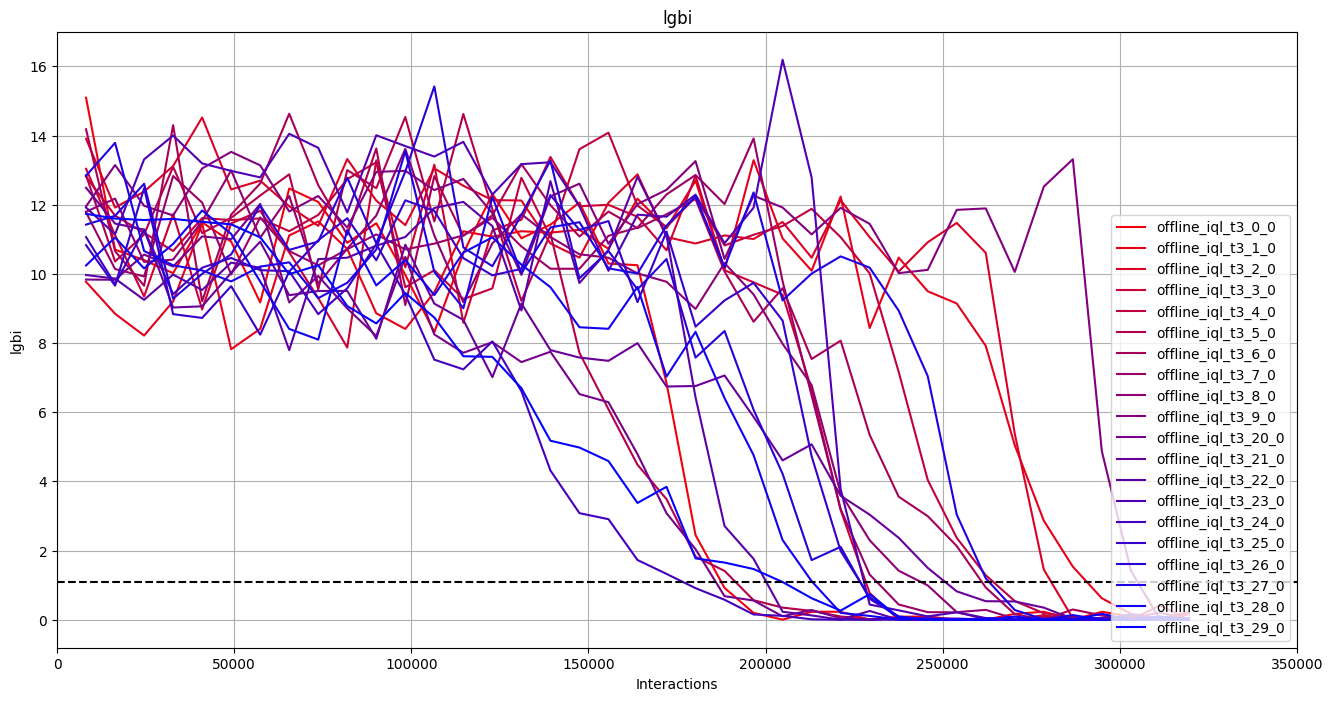

name	reward	fail	hgbi	tir	ri
offline_iql_t3_0_0	256.07	----	0.0	11.08	37.99	11.08	1
offline_iql_t3_1_0	219.43	----	0.16	24.1	42.99	24.26	2
offline_iql_t3_2_0	213.16	----	0.0	26.05	30.69	26.05	3
offline_iql_t3_3_0	207.06	----	0.0	28.09	35.28	28.09	4
offline_iql_t3_4_0	208.05	----	0.0	27.74	35.56	27.74	5
offline_iql_t3_5_0	244.01	----	0.22	15.6	52.5	15.82	6
offline_iql_t3_6_0	146.81	----	0.0	17.14	56.66	17.14	7
offline_iql_t3_7_0	163.77	----	0.0	17.81	55.33	17.81	8
offline_iql_t3_8_0	257.5	----	0.01	10.65	59.38	10.66	9
offline_iql_t3_9_0	217.38	----	0.0	24.51	36.39	24.51	10
offline_iql_t3_20_0	229.48	----	0.0	20.31	35.76	20.31	11
offline_iql_t3_21_0	246.41	----	0.0	14.48	36.25	14.49	12
offline_iql_t3_22_0	194.92	----	0.0	32.3	16.67	32.3	13
offline_iql_t3_23_0	212.77	----	0.0	26.11	31.94	26.11	14
offline_iql_t3_24_0	241.01	----	0.0	16.32	37.43	16.32	15
offline_iql_t3_25_0	158.87	----	0.0	44.81	23.89	44.81	16
offline_iql_t3_26_0	138.07	----	0.05	52.82	16.94	52.87	17
offline_iql_t3_27_0	238

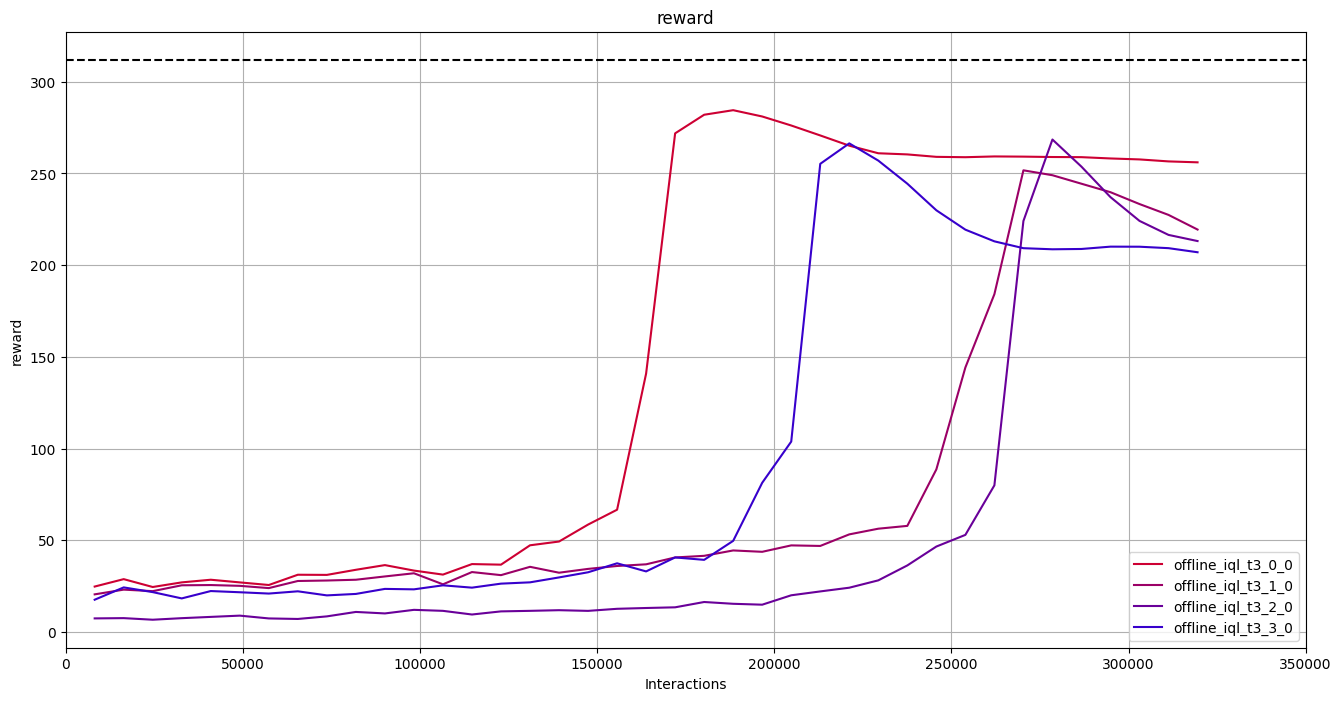

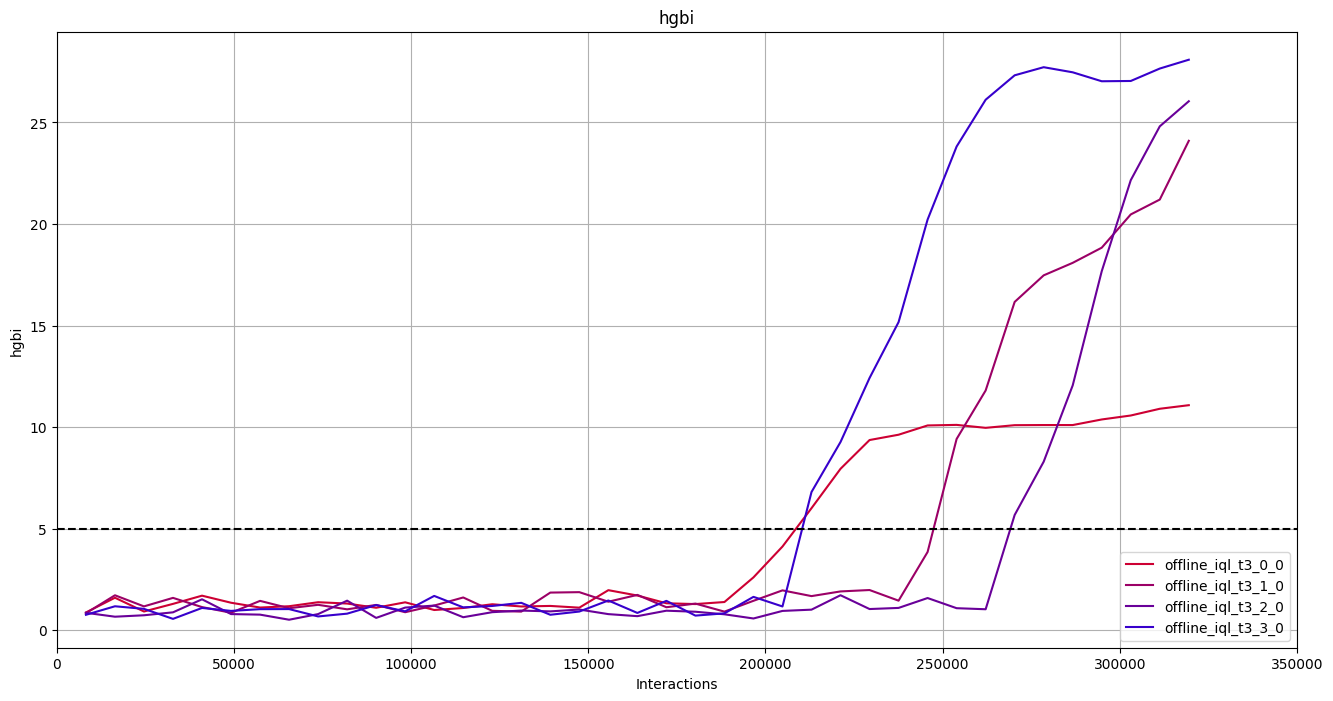

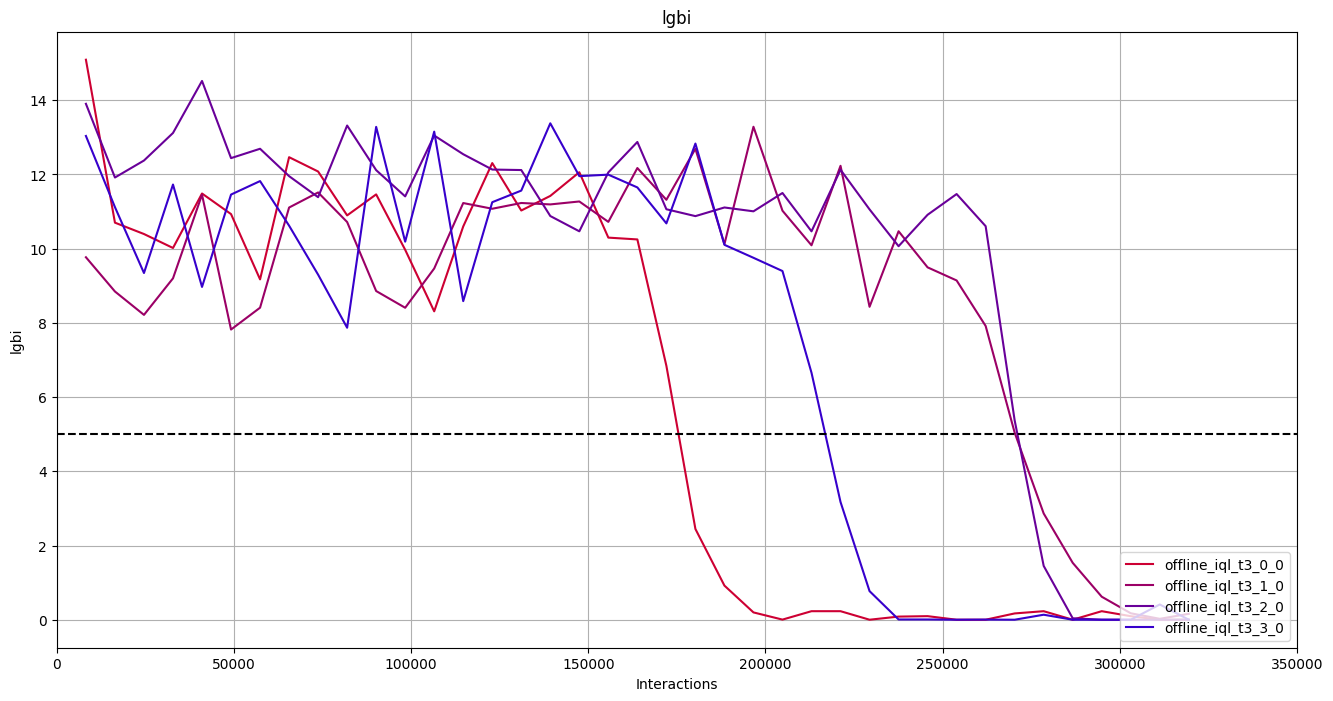

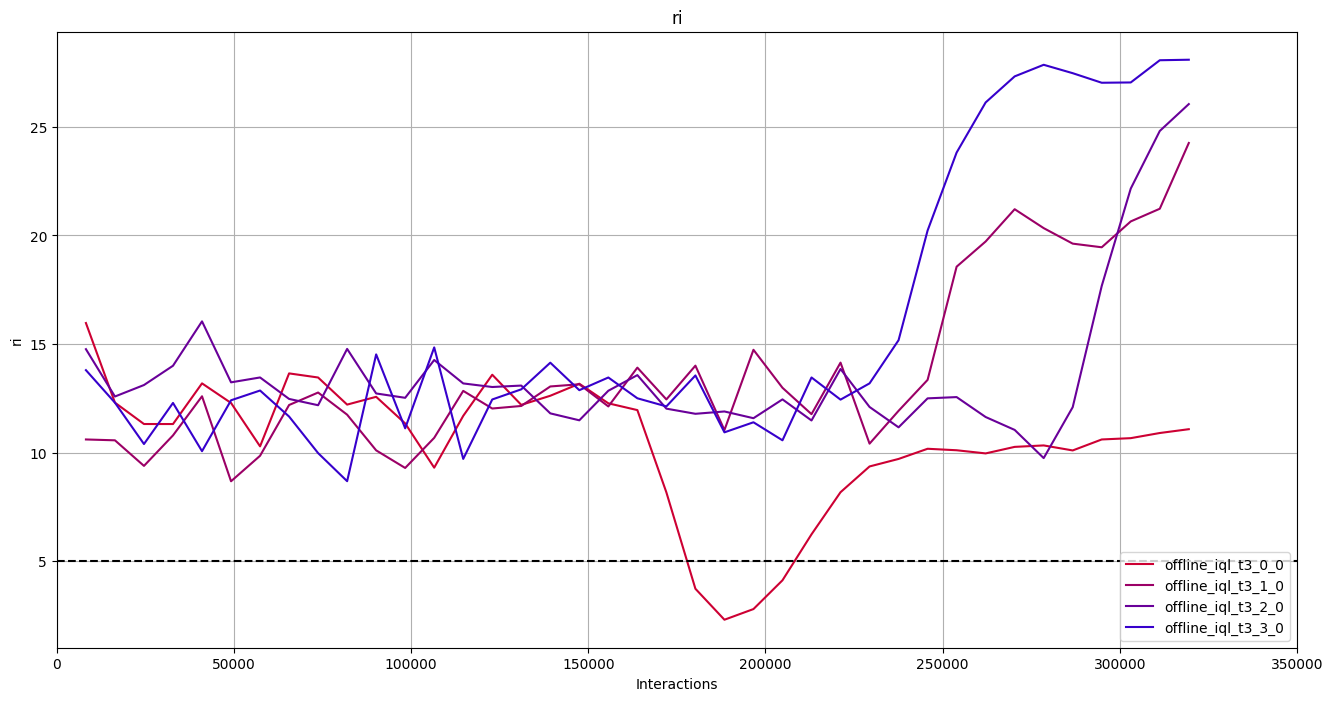

In [ ]:
import os
import sys
import json
import numpy as np
import pandas as pd
from decouple import config
MAIN_PATH = config('MAIN_PATH')
sys.path.insert(1, MAIN_PATH)
from visualiser.core import ExperimentVisualise, plot_testing_rewards, plot_training_logs, plot_value_function
from visualiser.core import plot_episode, plot_training_action_summary, plot_training_logs
from visualiser.core import display_commands, plot_testing_metric, display_commands_v2, create_file_paths
import matplotlib.gridspec
from matplotlib import pyplot as plt
%matplotlib inline 

def plot_testing_average_metric(dict, groups, type, dis_len, metric, goal, fill, title=None):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    for groupings in range(0, len(groups)):
        FILES = []
        for i in groups[groupings]:  # exp's inside the group
            # will give the exp list
            path, seeds, filename = dict[i]['id'].get_file_paths()
            FILES = create_file_paths(path, seeds, filename, FILES)
        cur_length, full_arr, refined = [], [], []
        for file in FILES:
            reward_summary = pd.read_csv(file)
            cur_length.append(reward_summary.shape[0])
            full_arr.append(reward_summary[metric])
        for x in full_arr:
            refined.append(x[0:min(cur_length)])
        data = pd.concat(refined, axis=1)
        data['mean'] = data.mean(axis=1)

        if type == 'normal':
            data['std_dev'] = data.std(axis=1)
            data['max'] = data['mean'] + data['std_dev']  # * 2
            data['min'] = data['mean'] - data['std_dev']  # * 2
        else:
            data['max'] = data.max(axis=1)
            data['min'] = data.min(axis=1)

        data['steps'] = np.arange(len(data))
        data['steps'] = (data['steps'] + 1) * dict[i]['id'].training_workers * dict[i]['id'].args['agent']['n_step']

        ax.plot(data['steps'], data['mean'], color=dict[i]['color'], label=dict[i]['label'])
        if fill:
            ax.fill_between(data['steps'], data['min'], data['max'], color=dict[i]['color'], alpha=0.1)

    #ax.axhline(y=goal, color='k', linestyle='--')

    graph_title =  title if title is not None else 'Average Rewards (Multiple Seeds)'
    ax.set_title(graph_title, fontsize=32)
    # ax.legend(loc="upper left", fontsize=16)
    ax.set_ylabel('Total Reward', fontsize=24) #ax.set_ylabel(metric)
    ax.set_xlabel('Steps', fontsize=24)
    ax.grid()
    ax.set_xlim(0, dis_len)
    ax.set_ylim(0, 320)
    plt.show()


exp_names = []
for patient_id in list(range(0,10)) + list(range(20,30)):
        exp_names.append(f"{name_prefix}_{patient_id}_{seed}") 


COHORT = 'Adult'
SUBJECT = '0'

LABEL = COHORT+SUBJECT

SINGLE_VIEW = False


command = []
dis_len = 3.5 * 100000 #1.0 * 1000000 /2 
disp_arr = display_commands_v2(command)


exp_vis = {
}

EXP_NUM = len(exp_names)
c = 1
for exp_name in exp_names:
    col = (255 - (250 * (c / EXP_NUM)), 0, 255 * c / EXP_NUM)
    # hex_st_col = '#' + ''.join([hex(int(round(chnl)))[3:] for chnl in col])
    hex_st_col = '#%02x%02x%02x' % tuple([int(round(i)) for i in col])
    try:
        exp_n = ExperimentVisualise(id=exp_name, version=1.1, plot_version=1, test_seeds=5000)
        exp_vis[str(c)] = { "id":exp_n, "color":hex_st_col ,"show": disp_arr[c], "label":exp_n.id}
        c += 1
    except:
        print("Left on", exp_name)
        break

plot_testing_average_metric({'1' : exp_vis['1']}, [['1']], type='normal', dis_len=dis_len, metric='reward', goal=312, fill=True)


# plot the graphs

# average metric


print(exp_vis['1'])


#individual seed metrics
plot_testing_metric(exp_vis, type='normal', dis_len=dis_len, metric='reward', goal=312, fill=False, label=False)  # normal
#plot_training_logs(exp_vis, dis_len, version=3)


# plot_testing_metric(exp_vis, type='min_max', dis_len=dis_len, metric='value_grad', goal=5, fill=False)
# plot_testing_metric(exp_vis, type='min_max', dis_len=dis_len, metric='val_loss', goal=1.1, fill=False)

params = ['policy_grad', 'explained_var', 'true_var','val_loss', 'value_grad']#, "td3_loss"] #, 'pi_loss'
plot_training_logs(mode='ppo', exp_dict=exp_vis, dis_len=dis_len, params=params)
# params = ['pi_aux_grad'] #'pi_aux_loss', 'vf_aux_loss', vf_aux_grad 
# plot_training_logs(mode='aux', exp_dict=exp_vis, dis_len=250, params=params)
# params = ['plan_grad', 'plan_loss'] 
# plot_training_logs(mode='planning', exp_dict=exp_vis, dis_len=250, params=params)    


plot_testing_metric(exp_vis, type='min_max', dis_len=dis_len, metric='aBGP_rmse', goal=15, fill=False)
#plot_testing_metric(exp_vis, type='min_max', dis_len=dis_len, metric='cBGP_rmse', goal=10, fill=False)
# plot_testing_metric(exp_vis, type='min_max', dis_len=dis_len, metric='normo', goal=70, fill=False)  # normal
plot_testing_metric(exp_vis, type='min_max', dis_len=dis_len, metric='ri', goal=5, fill=False)
plot_testing_metric(exp_vis, type='min_max', dis_len=dis_len, metric='hgbi', goal=5, fill=False)
plot_testing_metric(exp_vis, type='min_max', dis_len=dis_len, metric='lgbi', goal=1.1, fill=False)

T = 23
print('\t'.join(["name", "reward", "fail", "hgbi", "tir", "ri"]))
items = []
for n in range(EXP_NUM):
    exp = exp_vis[str(n+1)]
    name = exp["label"]
    res = exp["id"].get_summary_dict()

    T = list(res[0]["reward"].keys())[0]

    reward = round(np.mean([i["reward"][T] for i in res]),2)
    hgbi = round(np.mean([i["hgbi"][T] for i in res]),2)
    lgbi = round(np.mean([i["lgbi"][T] for i in res]),2)
    ri = round(np.mean([i["ri"][T] for i in res]),2)
    tir = round(np.mean([i["normo"][T] for i in res]),2)
    # print(name, reward, '----', hgbi, ri, sep='\t')
    items.append( (name, reward, '----', lgbi, hgbi, tir, ri, n+1) )

# items = list(sorted(items, key=lambda k : -k[-3]))

for item in items:
    print(*item, sep='\t')

print("table end")

SORTED_N = 5

new_exp_vis = dict()
n = 1
for item in items:
    col = (255 - (250 * (n / SORTED_N)), 0, 255 * n / SORTED_N)
    hex_st_col = '#%02x%02x%02x' % tuple([int(round(i)) for i in col])

    if n < SORTED_N:
        c = str(item[-1])
        new_exp_vis[c] = exp_vis[c]
        new_exp_vis[c]["color"] = hex_st_col

    n += 1


plot_testing_metric(new_exp_vis, type='normal', dis_len=dis_len, metric='reward', goal=312, fill=False, label=False)  # normal
plot_testing_metric(new_exp_vis, type='min_max', dis_len=dis_len, metric='hgbi', goal=5, fill=False)
plot_testing_metric(new_exp_vis, type='min_max', dis_len=dis_len, metric='lgbi', goal=5, fill=False)
plot_testing_metric(new_exp_vis, type='min_max', dis_len=dis_len, metric='ri', goal=5, fill=False)



In [5]:
T = 23
print('\t'.join(["name", "reward", "fail", "hgbi", "ri"]))
items = []
for n in range(EXP_NUM):
    exp = exp_vis[str(n+1)]
    name = exp["label"]
    res = exp["id"].get_summary_dict()

    T = list(res[0]["reward"].keys())[0]

    reward = round(np.mean([i["reward"][T] for i in res]),2)
    hgbi = round(np.mean([i["hgbi"][T] for i in res]),2)
    ri = round(np.mean([i["ri"][T] for i in res]),2)
    # print(name, reward, '----', hgbi, ri, sep='\t')
    items.append( (name, reward, '----', hgbi, ri, n+1) )

name	reward	fail	hgbi	ri
